In [4]:
from transformers import AutoModel, AutoTokenizer
import numpy as np

In [7]:
model = AutoModel.from_pretrained('julien-c/bert-xsmall-dummy')
tokenizer = AutoModel.from_pretrained('julien-c/bert-xsmall-dummy')

In [11]:
indices = np.random.default_rng().choice(10, 10, replace=False)
selected = np.full((15,), False)
selected[indices] = True
selected


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False])

In [20]:
model.train()
model.training

True

In [129]:
import numpy as np


class ALDataLoaderIterator:
    def __init__(self, dataset, selected, batch_size, shuffle):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indices = np.nonzero(selected)[0]
        if shuffle:
            self.indices = np.random.permutation(self.indices)
        self.i = 0

    def __next__(self):
        if self.i >= len(self.indices):
            raise StopIteration

        first_idx = self.i
        next_idx = min(self.i + self.batch_size, len(self.indices))
        assert next_idx > first_idx
        batch = [self.dataset[self.indices[j]] for j in range(first_idx, next_idx)]
        self.i = next_idx
        return batch


class ALDataLoader:
    def __init__(self, dataset, batch_size, shuffle_train, seed=0):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle_train = shuffle_train
        self.n = len(dataset)
        self.selected = np.full((self.n,), False)
        self.rng = np.random.default_rng(seed=seed)
        self.training = True
        self.selection_indices = None

    def select_indices(self, indices):
        assert not np.any(self.selected[indices])
        self.selected[indices] = True

    def select_k_at_random(self, k):
        not_selected = np.nonzero(~self.selected)[0]
        assert k <= len(not_selected)
        indices = self.rng.choice(not_selected, k, replace=False)
        self.select_indices(indices)

    def train(self):
        assert not self.training
        self.training = True
        self.selection_indices = None

    def selection(self):
        assert self.training
        assert self.selection_indices is None
        self.training = False

    def __iter__(self):
        if self.training:
            return ALDataLoaderIterator(self.dataset, self.selected, self.batch_size,
                                        self.shuffle_train)

        iterator = ALDataLoaderIterator(self.dataset, ~self.selected, self.batch_size,
                                        shuffle=False)
        self.selection_indices = iterator.indices
        return iterator

In [153]:
#from ALDataLoader import ALDataLoader

aldl = ALDataLoader(['e0', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7'],
                    batch_size=4, shuffle_train=True, seed=None)
aldl.select_k_at_random(2)
aldl.select_k_at_random(2)
for batch in aldl:
    print(batch)

aldl.selection()
for batch in aldl:
    print(batch)
print(aldl.selection_indices)

['e2', 'e0', 'e5', 'e3']
['e1', 'e4', 'e6', 'e7']
[1 4 6 7]


In [88]:
~np.full(5, True)

array([False, False, False, False, False])

In [2]:
import os
os.chdir('/home/david/Documents/PhD/old_src/sts_bert/sBERT')

In [3]:
from Percolation import make_percolation_dataset, define_and_train, NN_one_hidden
train_set = make_percolation_dataset(n_examples=10000)
dev_set = make_percolation_dataset(n_examples=10000)
test_set = make_percolation_dataset(n_examples=1000)
#define_and_train(NN_one_hidden, {}, 10, train_set, test_set);

0.4814
0.4854
0.47


In [4]:
import torch.nn as nn
class NN_one_hidden(nn.Module):

    def __init__(self):
        super(NN_one_hidden, self).__init__()
        self.layers = nn.Sequential(nn.Flatten(), nn.Linear(64, 100),  # try 100 hidden neurons
            nn.ReLU(),
            # note that we need the brackets after nn.ReLU() and nn.Sigmoid(), because these
            # are classes that need to be instantiated
            nn.Linear(100, 1),
            nn.Sigmoid())  # we are predicting only two classes, so we can use one sigmoid neuron as output

    def forward(self, x):  # computes the forward pass ... this one is particularly simple
        x = self.layers(x)
        return x

    def __getattr__(self, item):
        if item == 'device':
            return 'cpu'
        return super().__getattr__(item)

In [5]:
import torch
import numpy as np
from tqdm import tqdm
from transformers import get_scheduler


def tolist(obj):
    if type(obj) == list:
        return obj
    return obj.tolist()


class Trainer:
    def __init__(self, model, train_dl, dev_dl, test_dl, num_epochs, optimizer,
                 lr_scheduler='constant', warmup_percent=0.0, loss_function=None):
        self.model = model
        self.train_dl = train_dl
        self.dev_dl = dev_dl
        self.test_dl = test_dl
        self.num_epochs = num_epochs
        self.optimizer = optimizer

        # LR scheduler.
        steps_per_epoch = len(train_dl)
        total_training_steps = num_epochs * steps_per_epoch
        if lr_scheduler == 'constant':
            lr_scheduler = 'constant_with_warmup'
        warmup_steps = int(total_training_steps * warmup_percent)
        print('Scheduler type: {}, epochs: {}, steps per epoch: {}, total steps: {}, '
              'warmup steps: {}'.format(lr_scheduler, num_epochs, steps_per_epoch,
                                        total_training_steps, warmup_steps))
        self.lr_scheduler = get_scheduler(lr_scheduler, optimizer, num_warmup_steps=warmup_steps,
                                          num_training_steps=total_training_steps)

        self.loss_function = loss_function

        # For early stopping.
        self.best_dev_performance = -np.inf
        self.best_model_epoch = 0
        self.best_model = None

        # Store training progress.
        self.training_progress = {'train_loss': [], 'train_performance': [], 'dev_loss': [],
                                 'dev_performance': []}

        # Debug functions to execute after each step/epoch.
        self.debug_step_function = None
        self.debug_epoch_function = None

    # Override
    def predict_batch(self, batch):
        raise NotImplementedError('Method predict_batch should be overridden.')

    def predict(self, dl, disable_progress_bar=False):
        pred = []
        gold = []
        for batch in tqdm(dl, disable=disable_progress_bar):
            batch_pred, batch_gold = self.predict_batch(batch)
            pred += tolist(batch_pred)
            gold += tolist(batch_gold)
        return pred, gold

    # Override
    @staticmethod
    def performance(pred, gold):
        raise NotImplementedError('Method performance should be overridden.')

    def score(self, dl, disable_progress_bar=False):
        pred, gold = self.predict(dl, disable_progress_bar=disable_progress_bar)
        loss = self.loss_function(torch.Tensor(pred).to(self.model.device),
                                  torch.Tensor(gold).to(self.model.device))
        performance = self.performance(np.array(pred), np.array(gold))
        return performance, loss

    def train(self, disable_progress_bar, eval_zero_shot=False, early_stopping=True, verbose=True):
        for epoch in range(-1, self.num_epochs):

            # Train epoch.
            if epoch >= 0:
                # Model in mode train.
                self.model.train()

                # Prepare variables for evaluating model during training.
                train_loss = 0
                train_pred = []
                train_gold = []

                for batch in tqdm(self.train_dl, disable=disable_progress_bar):
                    # Zero gradients.
                    self.optimizer.zero_grad()

                    # Forward pass.
                    batch_pred, batch_gold = self.predict_batch(batch)

                    # Remember predictions for evaluation.
                    train_pred += tolist(batch_pred)
                    train_gold += tolist(batch_gold)

                    # Compute the loss. Turn gold values into tensors before.
                    if type(batch_gold) == list:
                        batch_gold = torch.FloatTensor(batch_gold).to(self.model.device)
                    loss = self.loss_function(batch_pred, batch_gold)

                    # Store loss for evaluation. Storing sum instead of mean.
                    train_loss += loss.item() * batch_gold.shape[0]

                    if self.debug_step_function is not None:
                        self.debug_step_function(middle=True)

                    # Backward pass.
                    loss.backward()

                    # Step optimizer, lr_scheduler and debug_function.
                    self.optimizer.step()
                    if self.lr_scheduler is not None:
                        self.lr_scheduler.step()
                    if self.debug_step_function is not None:
                        self.debug_step_function(middle=False)

                # Print evaluation.
                train_performance = self.performance(np.array(train_pred), np.array(train_gold))
                if verbose:
                    print('Train epoch {:<4d}: loss: {:<8.4f}, score: {:<8.4f}'.format(
                        epoch + 1, train_loss / len(batch_pred), train_performance))
                self.training_progress['train_loss'].append(train_loss)
                self.training_progress['train_performance'].append(train_performance)

                if self.debug_epoch_function is not None:
                    self.debug_epoch_function()

            if epoch >= 0 or eval_zero_shot:
                self.model.eval()
                dev_performance, dev_loss = self.score(self.dev_dl,
                                                       disable_progress_bar=disable_progress_bar)
                ast = ''
                if dev_performance > self.best_dev_performance:
                    self.best_model = self.model.state_dict()
                    self.best_dev_performance = dev_performance
                    self.best_model_epoch = epoch
                    ast = '*'
                if verbose:
                    print('Dev epoch {:<4d}: loss: {:<8.4f}, score: {:<8.4f}'.format(
                        epoch + 1, dev_loss, dev_performance) + ast)
                self.training_progress['dev_loss'].append(dev_loss)
                self.training_progress['dev_performance'].append(dev_performance)

                if early_stopping and epoch + 1 >= (self.num_epochs + 1) // 2 and \
                        self.best_model_epoch <= epoch - 2:
                    if verbose:
                        print('Early stopping')
                    break

        self.model.load_state_dict(self.best_model)

In [6]:

import numpy as np
import torch


class ALDataLoaderIterator:
    def __init__(self, dataset, selected, batch_size, shuffle):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indices = np.nonzero(selected)[0]
        if shuffle:
            self.indices = np.random.permutation(self.indices)
        self.i = 0

    def __next__(self):
        if self.i >= len(self.indices):
            raise StopIteration

        first_idx = self.i
        next_idx = min(self.i + self.batch_size, len(self.indices))
        assert next_idx > first_idx
        batch = {key: [self.dataset[self.indices[j]][key] for j in range(first_idx, next_idx)] for
                 key in self.dataset[0].keys()}
        for key in self.dataset[0].keys():
            if type(batch[key][0]) == torch.Tensor:
                batch[key] = torch.cat(batch[key])
        self.i = next_idx
        return batch


class ALDataLoader:
    def __init__(self, dataset, batch_size, shuffle_train, seed=0):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle_train = shuffle_train
        self.n = len(dataset)
        self.selected = np.full((self.n,), False)
        self.rng = np.random.default_rng(seed=seed)
        self.training = True
        self.selection_indices = None

    def select_indices(self, indices):
        assert not np.any(self.selected[indices])
        self.selected[indices] = True

    def select_k_at_random(self, k):
        not_selected = np.nonzero(~self.selected)[0]
        assert k <= len(not_selected)
        indices = self.rng.choice(not_selected, k, replace=False)
        self.select_indices(indices)

    def train(self):
        self.training = True
        self.selection_indices = None

    def selection(self):
        self.training = False

    def __iter__(self):
        if self.training:
            return ALDataLoaderIterator(self.dataset, self.selected, self.batch_size,
                                        self.shuffle_train)

        iterator = ALDataLoaderIterator(self.dataset, ~self.selected, self.batch_size,
                                        shuffle=False)
        self.selection_indices = iterator.indices
        return iterator

    def __len__(self):
        if 'warning_issued' not in dir(self):
            print('Warning: called ALDataLoader::__len__ but it has variable length. Returning '
                  'total possible length.')
            self.warning_issued = True
        return (len(self.dataset) - 1) // self.batch_size + 1

In [46]:
import torch
#from ActiveLearning.ALDataLoader import ALDataLoader
#from Trainer import Trainer

class PercolationTrainer(Trainer):
    def __init__(self, train_dl, dev_dl, test_dl, load_model=None, n_epochs=10):
        model = NN_one_hidden()
        if load_model is not None:
            model.load_state_dict(load_model.state_dict())
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        super().__init__(model, train_dl=train_dl, dev_dl=dev_dl, test_dl=test_dl,
                         num_epochs=n_epochs, optimizer=optimizer, loss_function=torch.nn.BCELoss())

    def predict_batch(self, batch):
        images = batch['image']
        labels = batch['label']
        if len(labels.shape) > 1:
            labels = labels.squeeze(1)
        outputs = self.model(images).squeeze(1)
        return outputs, labels

    @staticmethod
    def performance(pred, gold):
        return ((pred > 0.5) == (gold > 0.5)).mean()

batch_size = 32
train_dl = ALDataLoader(train_set, batch_size=batch_size, shuffle_train=True)
train_dl.select_k_at_random(1000)
dev_dl = torch.utils.data.DataLoader(dev_set, batch_size=batch_size, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
trainer = PercolationTrainer(train_dl, dev_dl, test_dl)

Scheduler type: constant_with_warmup, epochs: 10, steps per epoch: 313, total steps: 3130, warmup steps: 0


In [64]:
k = 250
times = 20

batch_size = 32
original_model = NN_one_hidden()
original_model = None
dev_dl = torch.utils.data.DataLoader(dev_set, batch_size=batch_size, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

def run_experiment(mode='lc'):
    train_dl = ALDataLoader(train_set, batch_size=batch_size, shuffle_train=True)
    train_dl.select_k_at_random(k)

    training_progresses = []
    dev_performances = []

    for i in range(times):
        trainer = PercolationTrainer(train_dl, dev_dl, None, load_model=original_model, n_epochs=20)
        train_dl.train()
        trainer.train(disable_progress_bar=True, verbose=False, eval_zero_shot=True,
                      early_stopping=False)
        training_progresses.append(trainer.training_progress)
        dev_performances.append(trainer.best_dev_performance)
        print('Dataloader size: {}, score: {}'.format(np.sum(train_dl.selected),
                                                      trainer.best_dev_performance))

        if mode == 'rnd':
            train_dl.select_k_at_random(k)
        else:
            train_dl.selection()
            probs, _ = trainer.predict(train_dl, disable_progress_bar=True)
            probs = np.expand_dims(np.array(probs), 1)
            confidences = np.concatenate((probs, 1 - probs), axis=1).max(axis=1)
            if mode == 'mc':
                confidences = -confidences
            else:
                assert mode == 'lc'
            lc_indices = np.argpartition(confidences, range(k))[:k]
            train_dl.select_indices(train_dl.selection_indices[lc_indices])

    return training_progresses, dev_performances

progress_lc, performance_lc = run_experiment(mode='lc')
progress_mc, performance_mc = run_experiment(mode='mc')
progress_rnd, performance_rnd = run_experiment(mode='rnd')

Scheduler type: constant_with_warmup, epochs: 20, steps per epoch: 313, total steps: 6260, warmup steps: 0
Dataloader size: 250, score: 0.5311
Scheduler type: constant_with_warmup, epochs: 20, steps per epoch: 313, total steps: 6260, warmup steps: 0
Dataloader size: 500, score: 0.5624
Scheduler type: constant_with_warmup, epochs: 20, steps per epoch: 313, total steps: 6260, warmup steps: 0
Dataloader size: 750, score: 0.5618
Scheduler type: constant_with_warmup, epochs: 20, steps per epoch: 313, total steps: 6260, warmup steps: 0
Dataloader size: 1000, score: 0.6048
Scheduler type: constant_with_warmup, epochs: 20, steps per epoch: 313, total steps: 6260, warmup steps: 0
Dataloader size: 1250, score: 0.618
Scheduler type: constant_with_warmup, epochs: 20, steps per epoch: 313, total steps: 6260, warmup steps: 0
Dataloader size: 1500, score: 0.649
Scheduler type: constant_with_warmup, epochs: 20, steps per epoch: 313, total steps: 6260, warmup steps: 0
Dataloader size: 1750, score: 0.66

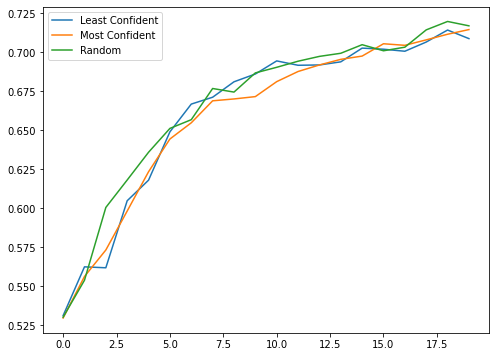

In [73]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']= [8, 6]
plt.plot(performance_lc, label='Least Confident')
plt.plot(performance_mc, label='Most Confident')
plt.plot(performance_rnd, label='Random')
plt.legend();

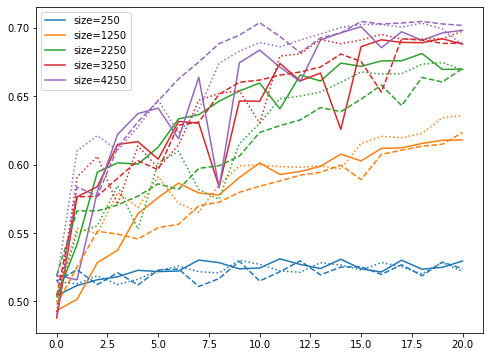

In [74]:
for i, tp in enumerate(progress_lc):
    if i%4 == 0:
        plt.plot(tp['dev_performance'], label='size={}'.format((i+1)*k), c='C{}'.format(i//4))
plt.legend();
for i, tp in enumerate(progress_mc):
    if i%4 == 0:
        plt.plot(tp['dev_performance'], label='size={}'.format((i+1)*k), linestyle='--', c='C{}'
                 .format(i//4))
for i, tp in enumerate(progress_rnd):
    if i%4 == 0:
        plt.plot(tp['dev_performance'], label='size={}'.format((i+1)*k), linestyle=':', c='C{}'
                 .format(i//4))
